In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# --- Configuration ---
preprocessed_path = r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images' 
input_shape = (128, 128, 3)  
batch_size = 64
num_epochs = 20 

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Setting up Training Generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'train'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',
    shuffle=True             
)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training set.")

print("\nSetting up Validation Generator...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'val'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',            
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {val_generator.samples} images belonging to {val_generator.num_classes} classes in validation set.")

print("\nSetting up Testing Generator...")
test_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'test'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',            
    shuffle=False                # No need to shuffle Testing data
)
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes in validation set.")


Setting up Training Generator...
Found 30580 images belonging to 10 classes.
Found 30580 images belonging to 10 classes in training set.

Setting up Validation Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.

Setting up Testing Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.


In [7]:
# Get the number of classes from the generator
num_classes = train_generator.num_classes
if num_classes != val_generator.num_classes:
    print("Warning: Training and validation sets have different numbers of classes!")


In [8]:
base = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape   
)

# Freeze early blocks, fine-tune later ones
for layer in base.layers[:-20]:
    layer.trainable = False
print(f"VGG16 base model loaded. Trainable: {base.trainable}")


# Create the new model head
RN50_model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_1'), 
    layers.Dense(256, activation='relu', name='fc2'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_2'), 
    layers.Dense(128, activation='relu', name='fc3'),
    layers.BatchNormalization(),
    layers.Dropout(0.5, name='dropout_3'), 
    layers.Dense(num_classes, activation='softmax', name='predictions') 
], name="VGG16_Transfer_Learning")


optimizer = Adam(learning_rate=0.0001) 

RN50_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

print("\nModel Summary:")
RN50_model.summary()

VGG16 base model loaded. Trainable: True

Model Summary:


Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 4, 4, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,975,358 (205.90 MB)

 Trainable params: 5,457,418 (20.82 MB)

 Non-trainable params: 48,517,940 (185.08 MB)

In [39]:
# --- Define Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,          
    verbose=1,
    restore_best_weights=True 
)

model_checkpoint = ModelCheckpoint(
    filepath='best_RN50_model.keras', 
    monitor='val_loss',
    save_best_only=True, 
    verbose=1
)

In [40]:
# --- Train the Model ---
print(f"\nStarting training for up to {num_epochs} epochs (head only)...")
history = RN50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=num_epochs,
    callbacks=[early_stopping, model_checkpoint] 
)

print("\nTraining finished.")


Starting training for up to 20 epochs (head only)...
Epoch 1/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1806 - loss: 2.9982
Epoch 1: val_loss improved from inf to 1.27025, saving model to best_RN50_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.1808 - loss: 2.9972 - val_accuracy: 0.5156 - val_loss: 1.2702
Epoch 2/20
  1/443 ━━━━━━━━━━━━━━━━━━━━ 8:13 1s/step - accuracy: 0.2969 - loss: 1.7897
Epoch 2: val_loss did not improve from 1.27025
443/443 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2969 - loss: 1.7897 - val_accuracy: 0.5134 - val_loss: 1.2712
Epoch 3/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4142 - loss: 1.8091
Epoch 3: val_loss improved from 1.27025 to 0.92811, saving model to best_RN50_model.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.4143 - loss: 1.8088 - val_accuracy: 0.6786 - val_loss: 0.9281
Epoch 4/20
  1/443 ━━━━━━━━━━━━━━━━━━━━ 8:21 1s/step - accuracy: 0.6094 - loss: 1.2376
Epoch 4: val_loss did not

In [44]:
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_RN50_model.keras')

In [45]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=r'D:/FUCK!!/Pattern/Project/notebooks/new_preprocessed_RGB_images/test',    
    target_size=input_shape[:2],           
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False                          
)

Found 268 images belonging to 10 classes.


In [48]:
tf.keras.backend.clear_session()

model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_RN50_model.keras')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True    
)

loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {loss:.4f} — Test accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7704 - loss: 0.6499

Test loss: 0.7675 — Test accuracy: 0.7388


In [49]:
steps = int(np.ceil(test_gen.samples / batch_size))
pred_probs = model.predict(
    test_gen,
    steps = steps,
    verbose=1
)

pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = test_gen.classes
labels   = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(true_idxs, pred_idxs, target_names=labels))

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

Classification Report:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.83      0.95      0.88        40
American Foursquare architecture       0.78      0.78      0.78        37
        American craftsman style       0.71      0.81      0.76        21
   Ancient Egyptian architecture       0.73      0.61      0.67        18
           Art Deco architecture       0.65      0.46      0.54        24
        Art Nouveau architecture       0.74      0.85      0.79        20
            Baroque architecture       0.49      0.67      0.56        27
            Bauhaus architecture       0.91      0.78      0.84        27
         Beaux-Arts architecture       0.72      0.62      0.67        29
          Byzantine architecture       0.86      0.72      0.78        25

                        accuracy                           0.74       268
                       macro avg       0.74     

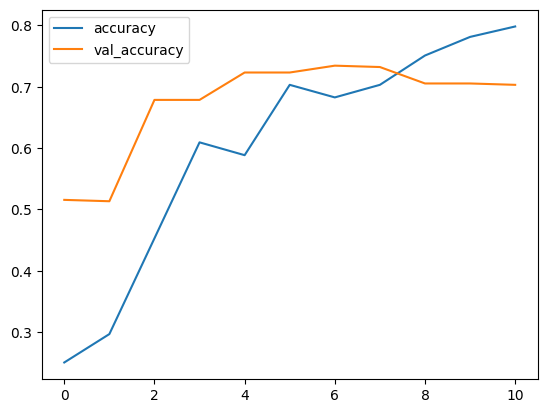

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.show()

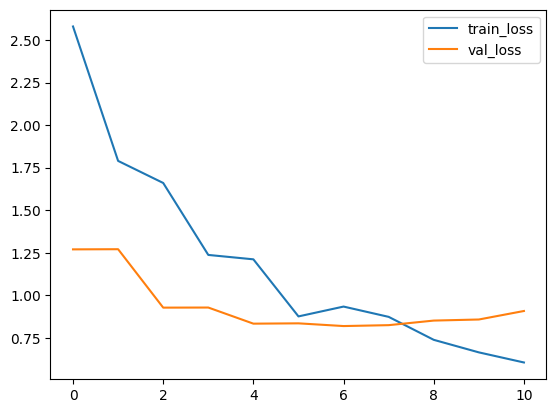

In [51]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()
